# Cross-correlation

We often encounter the need to match the pattern in two signals. For example, we may record a whale call at two different hydrophones and we may want to identify the difference in time when they occurred. Or we may want to match the pattern in an emitted signal to the return pattern reflected off an object to identify the time delay and the distance to the object. A widespread method is to find the offset at which the signals are most correlated, i.e. the patterns match.

Let's consider the two identical chirps which differ by their phase.



In [84]:
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

In [85]:
N = 1000
end_time = 1
freq = 50
time = np.linspace(0, end_time, end_time*N, endpoint=False)

In [86]:
def chirp_short_offset(offset):
   if offset>0.1 and offset<0.7:
       N = 1000
       time = np.linspace(0, end_time, N, endpoint=False) # 1 sec
       A = 1
       cw = A*np.sin(2*np.pi*freq*time) # zero phase
       left = np.zeros(int(offset*N))        
       middle_window = signal.windows.tukey(int(N/8), alpha=0.16)
       right = np.zeros(N-int(offset*N)-int(N/8))
       window = np.hstack((left, middle_window, right))
       cw_short =  cw * window
       return(cw_short)
   else:
       print("Offset out of range")
       

Text(0.5, 0, 'Time')

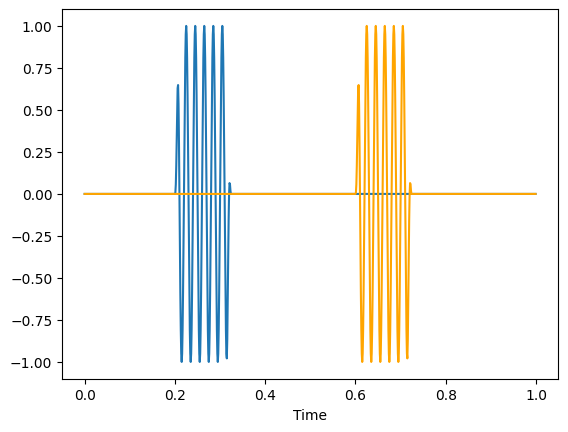

In [87]:
chirp1 = chirp_short_offset(offset=0.2)
chirp2 = chirp_short_offset(offset=0.6)

plt.plot(time, chirp1)
plt.plot(time, chirp2, "orange")
plt.xlabel("Time")

## Pattern Alignment

We want to shift in time one of the signals until it matches the other one. The correlation between two signals can be used as a measure of similarity between them. Calculating the correlation between a signal and shifted versions of the other signal at different lags allows us to find the best alignment corresponding to the lag with highest correlation. 

### Alignment Widget
We will demonstrate this idea with a widget the second signal backwards in time to match the first signal.

In [88]:
from ipywidgets import interact
import ipywidgets as widgets

In [89]:
def plot_shifted_chirp(time_shift):

    N = 1000
    end_time = 1
    time = np.linspace(0, end_time, end_time*N, endpoint=False)

    chirp1 = chirp_short_offset(offset=0.2)
    chirp2 = chirp_short_offset(offset=0.6+time_shift)

    plt.plot(time, chirp1)
    plt.plot(time, chirp2, "orange")
    plt.title("Signal Alignment")
    plt.xlabel("Time")

In [90]:
out = interact(plot_shifted_chirp, time_shift=(-0.4,0))

interactive(children=(FloatSlider(value=-0.2, description='time_shift', max=0.0, min=-0.4), Output()), _dom_cl…

### Cross-Correlation

The cross-correlation between two real continuous signals $f,g$ is defined as:

$$ R_{fg}(\tau) = \int_{-\infty}^{\infty} f(t) g(t+\tau) dt $$

where $\tau$ is the shift or lag, and the resulting function is a function of the lag. 

For discrete finite signals of lenght $M$ and $N$ this translates to:

$$R_{fg}[l] = \sum_{k=0}^{M-1}f[k]g[k+l]$$

where $k=-M,...,0, ... N$.

In [91]:
R = sp.signal.correlate(chirp1, chirp2)

In [92]:
R = signal.correlate(chirp1, chirp2, mode="full")
lags = signal.correlation_lags(chirp1.size, chirp2.size, mode="full")

Text(0.5, 0, 'Lag')

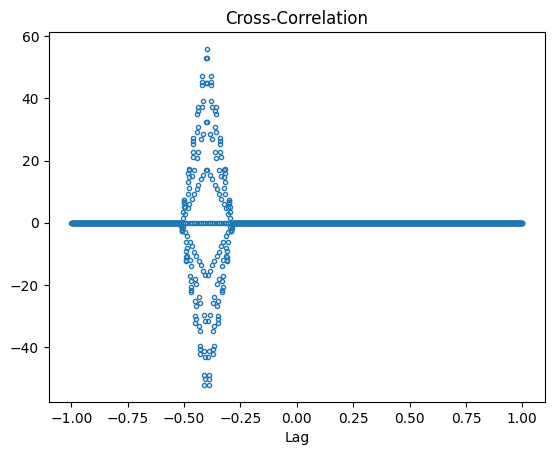

In [93]:
plt.plot(np.linspace(-1,1, len(lags)), R, '.', markerfacecolor='none')
plt.title("Cross-Correlation")
plt.xlabel("Lag")

We see that the lag of maximum correlation is around -0.4 and we can extract it by evaluating its `argmax`.

In [94]:
lag = lags[np.argmax(R)]
print(np.linspace(0,-1, 1000)[np.abs(lag)])

-0.40040040040040037


:::{caution}
Note, by default the `correlate` function computes all possible shifts, thus the output is an array of size $M+N-1$. When a signal is shifted it is padded with zeros to compute the correlation. If one wants to limit to the range to non-padded values, one can use the `mode = 'valid'` option or to align to the first signal the `mode = 'same'` option.
:::

### Cross-Correlation Widget

In [95]:
def plot_crosscorrelation(time_shift):

    # define two signals
    chirp1 = chirp_short_offset(offset=0.2)
    chirp2 = chirp_short_offset(offset=0.6+time_shift)
    N = 1000
    end_time = 1
    time = np.linspace(0, end_time, end_time*N, endpoint=False)

    # plot both signals
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(time, chirp1)
    ax1.plot(time, chirp2, "orange")
    ax1.set_xlabel("Time")
    ax1.title.set_text("Signals")
    fig.tight_layout()


    # cross-correlation
    R = sp.signal.correlate(chirp1, chirp2)
    R = signal.correlate(chirp1, chirp_short_offset(offset=0.6), mode="full")
    lags = signal.correlation_lags(chirp1.size, chirp2.size, mode="full")

    # plot cross-correlation
    ax2.plot(np.linspace(-1,0,1000),R[:1000])
    plt.plot(time_shift, R[np.abs(1000 + int(time_shift*1000))], 'ro')
    ax2.set_xlabel("Time Offset")
    ax2.title.set_text("Cross-correlation")
    fig.tight_layout()
    


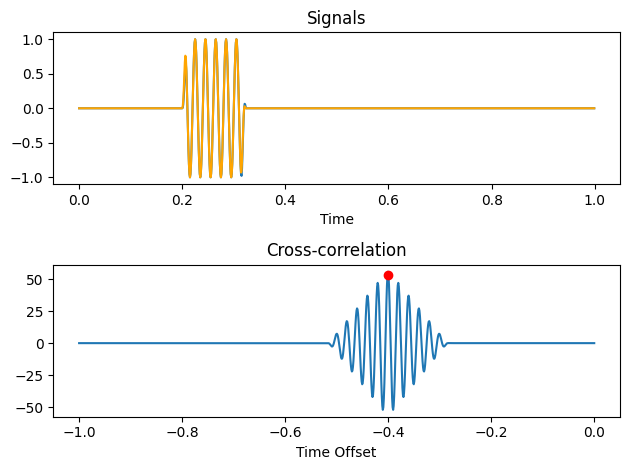

In [96]:
plot_crosscorrelation(-0.4)

In [97]:
time_shift_slider = widgets.FloatSlider(
    value=-0.4,
    min=-0.5,
    max=0,
    step=0.01,
    description='Time shift:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

out = interact(plot_crosscorrelation, time_shift=time_shift_slider)

interactive(children=(FloatSlider(value=-0.4, description='Time shift:', max=0.0, min=-0.5, readout_format='d'…

:::{note}
The approach of matching signals with cross-correlation is also called matched filtering.
:::